# Analysis of Citibike Data in NYC
## Introduction

The objective of this project is to analyze a large random sample of Citibike data from the years 2013 to 2019. We will look at different trends between location and month, as well as trends in the type of users and so much more. Hopefully after reading this tutorial, you will not only be able to understand more about different statistics/trends about the Citibike data, but also how much Citibike has become integrated in the lives of New Yorkers.

## Required Python Modules
The main python modules we will be using in our project are:
1. folium
2. requests
3. pandas
4. numpy
5. re
6. datetime
7. BeautifulSoup
8. json
9. matplotlib
10. sklearn

In [1]:
!pip install folium
import requests #for get request
import pandas as pd #pandas
import numpy as np #module
import re #regex
from datetime import datetime #datetime objects
from bs4 import BeautifulSoup #prettify's our content
import json #needed for google API
import os.path #needed for file reading
import matplotlib.pyplot as plt #for plotting
from sklearn import linear_model #for linear regression
from sklearn.preprocessing import PolynomialFeatures #polynomial regression
import folium
import urllib
import zipfile

     |████████████████████████████████| 92kB 2.2MB/s eta 0:00:01


## Data Collection

This is the data collection phase of the data life cycle. During this phase, our focus is on collecting and transforming the data into a usable form. In our case, that usable form is a pandas dataframe derived from a CSV file containing the original data. <br> <br>

After doing a lot of research for a dataset, we started to look towards the travel industry for motivation. We were motivated by data that contained information regarding ride sharing. At the end, we finalized our search on publicly available bike sharing data from Citi Bike NYC. We retrieved the data from the following site: https://s3.amazonaws.com/tripdata/index.html?fbclid=IwAR3BJ9yWYcKtBRYUMQq2SI1IZR9AnFel3C-eTato4mWXtwBz4olhrdrai7Js

The company had available several months worth of data, ranging from June of 2013 to October of 2019, so we decided to explore each of these months. In attempting to utilize the data from the entire data range mentioned, we needed to perform several steps to automate the download and collection process. The following process will describe how we went about collecting and manipulating the data into one aggregate dataframe containing a certain number of entries of each date. <br>

To collect and store the data, we used the following libraries from above:
1. urllib
2. zipfile
3. pandas

As mentioned before, the data was organized by year, and then month, so it was quite predictable in terms of figuring out how to extract the data files from the site. However, there were some unique aspects that required some workarounds. We looped through each year and month pair from June of 2013 to October of 2019. All of the month numbers in the file names had 2 digits, so we need to make sure all months before October (10th month) were **prepended with a "0"**. Most of the zip files followed the format **"{date}{month_2_digit}-citibike-tripdata.zip"**. The remaining zip files had a slightly different name format of **"{date}{month_2_digit}-citibike-tripdata.csv.zip"**. To get work around this, we instituted a check in the loop to determine if the current year was after 2016. If so, then the url and zip file name would be updated accordingly. 

Once those alterations were completed, as necessary, we proceeded to download the file data. To do so, we utilized the library function **urllib.request.urlretrieve** to download the zip file, indicated by the corresponding url, to the corresponding file path location, which was the current directory in this case. With the zip file downloaded, we proceeded to extract the contents of the zip file, only one CSV file in this case, using zipfile **extractall** method and extracted it to the current directory. We also retrieved the name of the file using the zipfile **namelist** and indexing at 0, as there is always only one element (CSV file) in said list. <br>
    
With the CSV data file download and extracted from the corresponding zip file, we transferred it into a pandas dataframe object. We made sure to add year and moth column to differentiate these data points from entries in future CSV files. After that, we decided to add only a sample of the resulting dataframe to our aggregate dataframe. This was due to the fact there were too many entries in every CSV file, so it would be impractical and inefficient to collect every data from each CSV for exploratory data analysis. With that in mind, we decided to randomly sample 10000 rows from each dataframe to be used for data analysis using the pandas **sample** method without replacement. In sampling with n=10000, we get a good representation of the data for that specific date.<br>
    
One issue we ran into when generating each sampled dataframe was with the column (attribute) names. We realized that, after approximately 2017, the attribute names were capitalized. Due to this difference, the resulting aggregate dataframe at first contained many NaNs because pandas concatenates dataframes based on their column names. The dataframe resulted in having 2 times the normal amount of column names: half being lowercase and half being capitalized. Ignoring case, the column names across all CSV files were identical. To work around this, we decided to create a list of default, lowercase column names, **col_names**, and replaced the column names of each sampled dataframe with our list. <br>
    
After iterating over each date, we ended up with a **list of 77 dataframes**, each corresponding to a specific date from the data. Since, we made sure that all of these dataframes had the same column names, we proceeded to concatenate all of them into one aggregate dataframe, as mentioned before. With 77 dataframes, each with 10000 randomly sampled data points, the new aggregate dataframe contained **770001** total data points. To do this, we utilized the pandas **concat** function, because it we could pass an iterable, which, in this case, was our list of sampled dataframes. The resulting dataframe was returned as output for display purposes.

In [ ]:
# The data begins starting on June of 2013. 
year = 2013
month = 6

# In some of the csv files, we found that the column names differed by 
# capitalization, so below is a standard list of the all of the column
# names that we apply to each sampled dataframe. 
col_names = ['tripduration', 'starttime', 'stoptime', 'start station id',
 'start station name', 'start station latitude', 'start station longitude',
 'end station id', 'end station name', 'end station latitude',
 'end station longitude', 'bikeid', 'usertype', 'birth year', 'gender', 'year',
 'month']

# A list to hold all of the dataframes
list_dfs = []

# The last csv file contains the data recorded on October of 2019. The
# loop will increment by 1 month, until after this date is reached. 
while (not (year == 2019 and month == 11)):
    date_str = f'{year}{month}'
    
    # If the month is before October (10), prepend the corresponding 
    # integer value with a 0 to make it 2 digits
    if month < 10:
        date_str = f'{year}0{month}'
    
    # Corresponding download URL for each relevant zip file
    url = f'https://s3.amazonaws.com/tripdata/{date_str}-citibike-tripdata.zip'
    # Corresponding name for each relevant zip file
    zip_file = f'{date_str}-citibike-tripdata.zip'
    
    # Format of zip file name changes after 2016, so this if stmt accounts for that
    if (year > 2016):
        url = f'https://s3.amazonaws.com/tripdata/{date_str}-citibike-tripdata.csv.zip'
        zip_file = f'{date_str}-citibike-tripdata.csv.zip'
    
    # Zip file path points to the current directory "."
    zip_file_path = f'./{zip_file}'
    
    print(year, month)
    
    # Download the corresponding zip file
    urllib.request.urlretrieve(url, zip_file)
    
    csv_filename = ''
    
    # Extract the csv from the zip file and get its name
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('.')
        csv_filename = zip_ref.namelist()[0]
    
    # Read the csv file into a pandas dataframe
    df = pd.read_csv(f'./{csv_filename}')
    
    # Add the year and month attributes to distinguish from entries
    # from entries from other dates
    df['year'] = year
    df['month'] = month  
    
    # Take a random sample of 10000 data points from the csv
    sampled_df = df.sample(10000, replace=False, random_state=1)  
    
    # Make sure that all of the dataframes have the same attribute formats
    sampled_df.columns = list(col_names)    
    print(sampled_df.columns.values)
    
    # Add the dataframe to a list containing all dataframes 
    list_dfs.append(sampled_df)   
    
    # Increment by 1 month. Increment the year by 1 if month goes past Dec.
    month += 1  
    if (month > 12):
        month = 1
        year += 1

# Concatenate all dataframes together to form a cumulative dataframe 
bikes_df = pd.concat(list_dfs)     
bikes_df

After creating the dataframe containing sampled observations from every date in the range of June of 2013 to October of 2019, we decided to export it to a CSV file for future use by using the pandas **to_csv** method. The reason behind this was because the process of downloading, extracting, and converting the data from the site was time and memory intensive. Another related thing to note was that kernel did die on occasion and had to restart. For this reason, rather than repeatedly performing these operations every time, we exported to the resulting dataframe to a CSV for efficiency purposes. It will later be converted back to a dataframe object when we begin our data analysis below. 

In [ ]:
# Write the dataframe to a csv file for later use and safe keeping
bikes_df.to_csv('./FINAL_SAMPLED_DATA.csv', index=False)

In [2]:
# Retrieve the saved dataset (FINAL_SAMPLED_DATA.csv) from zip file here
with zipfile.ZipFile('./FINAL_SAMPLED_DATA.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('.')
    csv_filename = zip_ref.namelist()[0]
bikes_df = pd.read_csv(csv_filename)
bikes_df

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,year,month
0,300,2013-06-30 19:21:20,2013-06-30 19:26:20,530.0,11 Ave & W 59 St,40.771522,-73.990541,449.0,W 52 St & 9 Ave,40.764618,-73.987895,17034,Subscriber,1969.0,1,2013,6
1,616,2013-06-29 15:40:45,2013-06-29 15:51:01,238.0,Bank St & Washington St,40.736197,-74.008592,79.0,Franklin St & W Broadway,40.719116,-74.006667,19847,Customer,NaN,0,2013,6
2,781,2013-06-26 12:59:35,2013-06-26 13:12:36,435.0,W 21 St & 6 Ave,40.741740,-73.994156,487.0,E 20 St & FDR Drive,40.733143,-73.975739,19195,Subscriber,1965.0,2,2013,6
3,1633,2013-06-21 18:42:01,2013-06-21 19:09:14,491.0,E 24 St & Park Ave S,40.740964,-73.986022,243.0,Fulton St & Rockwell Pl,40.688226,-73.979382,20195,Customer,NaN,0,2013,6
4,574,2013-06-02 09:10:43,2013-06-02 09:20:17,398.0,Atlantic Ave & Furman St,40.691652,-73.999979,2000.0,Front St & Washington St,40.702551,-73.989402,19606,Subscriber,1957.0,1,2013,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
769995,477,2019-10-18 18:11:08.4780,2019-10-18 18:19:06.1790,402.0,Broadway & E 22 St,40.740343,-73.989551,267.0,Broadway & W 36 St,40.750977,-73.987654,38486,Subscriber,1978,1,2019,10
769996,770,2019-10-01 18:52:59.1080,2019-10-01 19:05:50.0560,3016.0,Kent Ave & N 7 St,40.720368,-73.961651,3452.0,Bayard St & Leonard St,40.719156,-73.948854,35125,Customer,1969,0,2019,10
769997,250,2019-10-04 15:38:44.3080,2019-10-04 15:42:54.4630,301.0,E 2 St & Avenue B,40.722174,-73.983688,401.0,Allen St & Rivington St,40.720196,-73.989978,34112,Subscriber,1986,1,2019,10
769998,594,2019-10-18 21:08:55.7210,2019-10-18 21:18:49.8250,3707.0,Lexington Ave & E 26 St,40.741459,-73.983293,432.0,E 7 St & Avenue A,40.726218,-73.983799,14545,Subscriber,1991,2,2019,10


## Data Processing

We will first turn the starttime and stoptime column values into datetime objects. This will help us later on in the analysis when we need to access individual elements of the time (hour, day, year etc.). The format of the datetime object will be 'year-month-day hour:minute:second:millisecond'. We will be using Python's build-in function 'to_datetime' to help us convert the strings into datetime objects. 

In [3]:
# Convert starttime column values into datetime objects
bikes_df['starttime'] = pd.to_datetime(bikes_df['starttime'])

# Convert stoptime column values into datetime objects
bikes_df['stoptime'] = pd.to_datetime(bikes_df['stoptime'])

# Print the resulting dataframe
bikes_df


,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,year,month
0,300,2013-06-30 19:21:20.000,2013-06-30 19:26:20.000,530.0,11 Ave & W 59 St,40.771522,-73.990541,449.0,W 52 St & 9 Ave,40.764618,-73.987895,17034,Subscriber,1969.0,1,2013,6
1,616,2013-06-29 15:40:45.000,2013-06-29 15:51:01.000,238.0,Bank St & Washington St,40.736197,-74.008592,79.0,Franklin St & W Broadway,40.719116,-74.006667,19847,Customer,NaN,0,2013,6
2,781,2013-06-26 12:59:35.000,2013-06-26 13:12:36.000,435.0,W 21 St & 6 Ave,40.741740,-73.994156,487.0,E 20 St & FDR Drive,40.733143,-73.975739,19195,Subscriber,1965.0,2,2013,6
3,1633,2013-06-21 18:42:01.000,2013-06-21 19:09:14.000,491.0,E 24 St & Park Ave S,40.740964,-73.986022,243.0,Fulton St & Rockwell Pl,40.688226,-73.979382,20195,Customer,NaN,0,2013,6
4,574,2013-06-02 09:10:43.000,2013-06-02 09:20:17.000,398.0,Atlantic Ave & Furman St,40.691652,-73.999979,2000.0,Front St & Washington St,40.702551,-73.989402,19606,Subscriber,1957.0,1,2013,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
769995,477,2019-10-18 18:11:08.478,2019-10-18 18:19:06.179,402.0,Broadway & E 22 St,40.740343,-73.989551,267.0,Broadway & W 36 St,40.750977,-73.987654,38486,Subscriber,1978,1,2019,10
769996,770,2019-10-01 18:52:59.108,2019-10-01 19:05:50.056,3016.0,Kent Ave & N 7 St,40.720368,-73.961651,3452.0,Bayard St & Leonard St,40.719156,-73.948854,35125,Customer,1969,0,2019,10
769997,250,2019-10-04 15:38:44.308,2019-10-04 15:42:54.463,301.0,E 2 St & Avenue B,40.722174,-73.983688,401.0,Allen St & Rivington St,40.720196,-73.989978,34112,Subscriber,1986,1,2019,10
769998,594,2019-10-18 21:08:55.721,2019-10-18 21:18:49.825,3707.0,Lexington Ave & E 26 St,40.741459,-73.983293,432.0,E 7 St & Avenue A,40.726218,-73.983799,14545,Subscriber,1991,2,2019,10


## Exploratory Analysis and Data Visualization

We will be plotting our data and analyzing trends that may be significant. Some plots you will see are most popular starting points of trips, comparison between subscriber and customer of Citibikes, the day that most people use the Citibikes, and so much more. 

### Plotting Frequency of Start Time of Trip
We will be plotting the number of occurrences during the day when people begin their trip. 


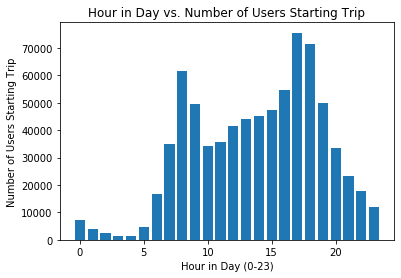

In [5]:
time_of_day = {}

# Fill time_of_day hash table with 0 occurrences of users for each hour
for i in range(0, 24):
    time_of_day[i] = 0

# Loop through dataframe and increase counts of users by one 
# for that hour if the user started the trip at that hour
for index, row in bikes_df.iterrows():
    datetime_obj = row['starttime']
    time_of_day[datetime_obj.hour] += 1

# We will now plot histogram of the time of day people start using the bikes.
plt.bar(time_of_day.keys(), time_of_day.values(), align='center')
plt.xlabel('Hour in Day (0-23)')
plt.ylabel('Number of Users Starting Trip')
plt.title('Hour in Day vs. Number of Users Starting Trip')
plt.show()

By looking at the graph above, most of the people rent Citibikes around 8am and 5pm. The reason for these two peaks at these two times could be that these two times correspond to when most people are going to work and leaving work.

### Plotting Most Popular Days of the Week

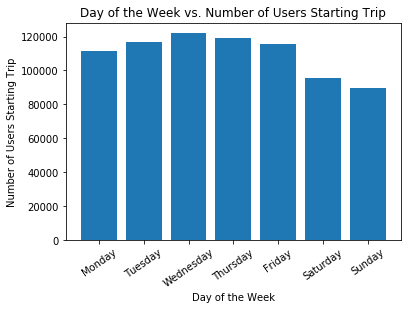

[0, 1, 2, 3, 4, 5, 6]


In [23]:
week_day= {}

# Fill time_of_day hash table with 0 occurrences of users for each hour
for i in range(0, 7):
    week_day[i] = 0

# Loop through dataframe and increase counts of users by one 
# for that hour if the user started the trip at that hour
for index, row in bikes_df.iterrows():
    datetime_obj = row['starttime']
    week_day[datetime_obj.weekday()] += 1

# We will now plot histogram of the time of day people start using the bikes.
days = ['Monday','Tuesday','Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday']
plt.bar(week_day.keys(), week_day.values(), align='center')
plt.xticks(list(week_day.keys()), days, rotation=35)
plt.xlabel('Day of the Week')
plt.ylabel('Number of Users Starting Trip')
plt.title('Day of the Week vs. Number of Users Starting Trip')
plt.show()

### Finding and Analyzing Source/Destination Stations
#### Heatmaps of Source/Destination Stations
We will be plotting the heatmap of source and destination locations. By plotting this, we will hopefully be able to analyze locations where most users retrieve and dock their bikes at in NYC. The brighter an area is (more orange/yellow) the more users that were in that area retrieving/docking their bikes. Feel free to zoom in too to take a closer look at the different areas in the city where most people are using Citibikes. 

The following is the Source Stations Heatmap: 

In [70]:
# The code below will plot the heatmap of source locations 
from folium.plugins import HeatMap
map_osm = folium.Map(location=[40.7358, -73.9760], zoom_start=11.5)

# Create HeatMap of the crimes in Baltimore
bikes_df['count'] = 1
HeatMap(data=bikes_df[['start station latitude', 'start station longitude', 'count']]
        .groupby(['start station latitude', 'start station longitude'])
        .sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(map_osm)

map_osm

The following is the Destination Stations HeatMap: 

In [71]:
# The code below will plot the heatmap of destination locations 
map_osm = folium.Map(location=[40.7358, -73.9760], zoom_start=11.5)

# Create HeatMap of the crimes in Baltimore
bikes_df['count'] = 1
HeatMap(data=bikes_df[['end station latitude', 'end station longitude', 'count']]
        .groupby(['end station latitude', 'end station longitude'])
        .sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(map_osm)

map_osm

By looking at the two maps above, at first glance, we can see that most people start their trips in the heart of Manhattan and Brooklyn. If we zoom in more, we can get a greater sense of where most people start/end their trips from. In the source destination heatmap, we can that around 45th street and the southernest part of Manhattan, there is a good amount of trips that start from the stations near there. Likewise, we can see the same trend in the destination heatmap. We can next plot the most popular starting stations and see them on the map.  

#### Plotting Popular Source/Destination Stations
Instead of plotting a heatmap, we can plot the top 10 source stations as well as the top 10 destination stations from all the years 2013-2019. By plotting this, we can see more about where these stations are on the map and see if they correspond to the high concentration of users on the heatmap above. 

Text(0.5, 1.0, 'Top 10 Destination Stations with Most Users')

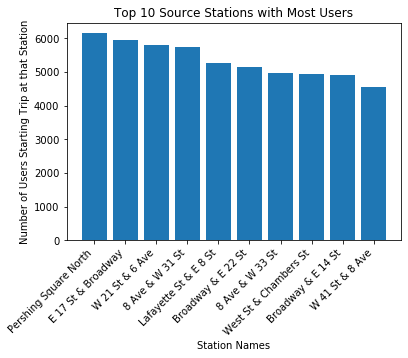

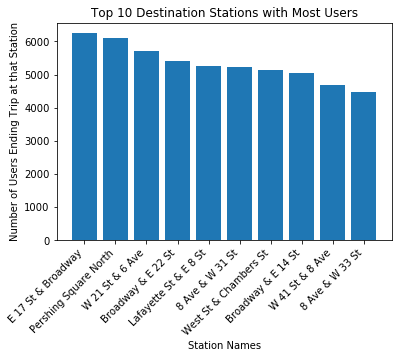

In [17]:
stations_start = {}
stations_end = {}

# Loop through dataframe and keep count of the number of people who leave 
# from the stations and arrive at the stations
for index, row in bikes_df.iterrows():
    station_name_start = row['start station name']
    station_name_end = row['end station name']
    
    if station_name_start not in stations_start:
        stations_start[station_name_start] = 0
        
    if station_name_end not in stations_end:
        stations_end[station_name_end] = 0
        
    stations_start[station_name_start] += 1
    stations_end[station_name_end] += 1

# Sort the hash by value and retrieve top 10 source/destination stations
stations_start = sorted(stations_start.items(), key=lambda x:-x[1])[:10]
stations_end = sorted(stations_end.items(), key=lambda x:-x[1])[:10]

# Extract first 10 highest items from hash (stations with most users)
# and fill up the x and y lists that we will plot
top_x_start = []
top_y_start = []
top_x_end = []
top_y_end = []
for key, value in stations_start:
    top_x_start.append(key)
    top_y_start.append(value)
    
for key, value in stations_end:
    top_x_end.append(key)
    top_y_end.append(value)

# We will now plot histogram of the top 10 stations that people start and end
fig, ax1 = plt.subplots()
ax1.bar(top_x_start, top_y_start, align='center')
ax1.set_xlabel('Station Names')
ax1.set_xticklabels(top_x_start, rotation = 45, ha='right')
ax1.set_ylabel('Number of Users Starting Trip at that Station')
ax1.set_title('Top 10 Source Stations with Most Users')

fig, ax2 = plt.subplots()
ax2.bar(top_x_end, top_y_end, align='center')
ax2.set_xlabel('Station Names')
ax2.set_xticklabels(top_x_end, rotation = 45, ha='right')
ax2.set_ylabel('Number of Users Ending Trip at that Station')
ax2.set_title('Top 10 Destination Stations with Most Users')


We can see what the most popular stations are in the histogram, but now let's see where they are on the map. First, we will graph the most popular source stations below. 

In [35]:
map_osm = folium.Map(location=[40.7300, -74.0007], zoom_start=13)

# Add points to map to show most popular source stations
for name in top_x_start:
    # Retrieve the latitude and longitude of that location in dataframe     
    row = bikes_df.loc[bikes_df['start station name'] == name].iloc[0]
    lat = row['start station latitude']
    long = row['start station longitude']
    
    # Add a circle indicating the location in NYC
    folium.Circle(
        radius=20,
        location=[lat, long],
        popup=name,
        color='black',
        fill=True,
    ).add_to(map_osm)

map_osm


Likewise, we will graph the top 10 destination stations below

In [34]:
map_osm = folium.Map(location=[40.7300, -74.0007], zoom_start=13)

# Add points to map to show most popular destination stations
for name in top_x_end:
    # Retrieve the latitude and longitude of that location in dataframe     
    row = bikes_df.loc[bikes_df['end station name'] == name].iloc[0]
    lat = row['end station latitude']
    long = row['end station longitude']
    
    # Add a circle indicating the location in NYC      
    folium.Circle(
        radius=20,
        location=[lat, long],
        popup=name,
        color='red',
        fill=True,
    ).add_to(map_osm)

map_osm


TODO: We write the conclusion here...

### Comparing Habits Between Subscribers and Customers (day-pass and single-ride users)

In [32]:
customers = bikes_df.loc[bikes_df['usertype'] == "Customer"]
subscribers = bikes_df.loc[bikes_df['usertype'] == "Subscriber"]

### Customer vs Subscriber Frequency By Day of Week

TODO: Standardize for better comparison

In [38]:
# compare day of week,
week_day_sub= {}
week_day_cust= {}

# Fill time_of_day hash table with 0 occurrences of users for each hour
for i in range(0, 7):
    week_day_sub[i] = 0
    week_day_cust[i] = 0

# Loop through dataframe and increase counts of users by one 
# for that hour if the user started the trip at that hour
for index, row in bikes_df.iterrows():
    datetime_obj = row['starttime']
    if row['usertype'] == 'Customer':
        week_day_cust[datetime_obj.weekday()] += 1
    elif row['usertype'] == 'Subscriber':
        week_day_sub[datetime_obj.weekday()] += 1

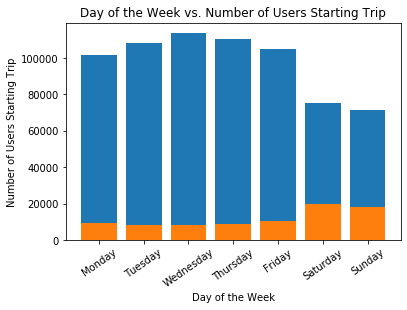

In [40]:
plt.bar( week_day_sub.keys(), week_day_sub.values())
plt.bar( week_day_cust.keys(), week_day_cust.values())

days = ['Monday','Tuesday','Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday']
plt.xlabel('Day of the Week')
plt.xticks(list(week_day_cust.keys()), days, rotation=35)
plt.ylabel('Number of Users Starting Trip')
plt.title('Day of the Week vs. Number of Users Starting Trip')
plt.show()

### Customer vs Subscriber Frequency By Time of Day

TODO: Standardize for better comparison

In [43]:
# compare time of day

# compare day of week,
time_sub= {}
time_cust= {}

# Fill time_of_day hash table with 0 occurrences of users for each hour
for i in range(0, 24):
    time_sub[i] = 0
    time_cust[i] = 0

# Loop through dataframe and increase counts of users by one 
# for that hour if the user started the trip at that hour
for index, row in bikes_df.iterrows():
    datetime_obj = row['starttime']
    if row['usertype'] == 'Customer':
        time_cust[datetime_obj.hour] += 1
    elif row['usertype'] == 'Subscriber':
        time_sub[datetime_obj.hour] += 1

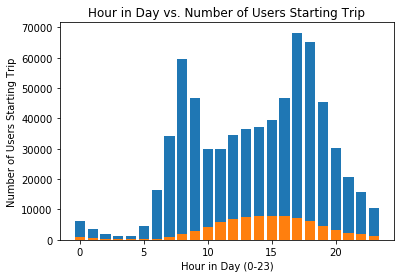

In [48]:
plt.bar(list(time_sub.keys()), list(time_sub.values()))
plt.bar(list(time_cust.keys()), list(time_cust.values()))
plt.xlabel('Hour in Day (0-23)')
plt.ylabel('Number of Users Starting Trip')
plt.title('Hour in Day vs. Number of Users Starting Trip')
plt.show()

# compare locations
# popular tourist locations?

### Heatmap of Trips for Customers vs Subscribers

In [ ]:
map_osm = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

bikes_df['count'] = 1
HeatMap(data=customers[['end station latitude', 'end station longitude']]
        .groupby(['end station latitude', 'end station longitude'])
        .sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(map_osm)

map_osm

In [ ]:
map_osm = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

bikes_df['count'] = 1
HeatMap(data=subscribers[['end station latitude', 'end station longitude']]
        .groupby(['end station latitude', 'end station longitude'])
        .sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(map_osm)

map_osm

## Analysis, Hypothesis Testing and Machine Learning

## Insight and Policy Decisions